In [2]:
# import statements
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('white')

from random import randrange
from time import time
import os
from google.colab import drive
import cv2
import imghdr
from tqdm import tqdm
from PIL import Image


In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
os.listdir('/content/drive/MyDrive/workout_img/test_dataset/train')

['bench', 'deadlift', 'squat']

In [6]:
data_dir_train = '/content/drive/MyDrive/workout_img/test_dataset/train'

In [7]:
len(os.listdir(os.path.join(data_dir_train,'bench')))

126

In [8]:
len(os.listdir(os.path.join(data_dir_train,'deadlift')))

161

In [9]:
len(os.listdir(os.path.join(data_dir_train,'squat')))

166

In [10]:
for image_class in os.listdir(data_dir_train):
  print(image_class)

bench
deadlift
squat


In [11]:
def load_im_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/MyDrive/workout_img/test_dataset/train'
    elif loading_method == 'direct':
        data_path = 'flowers/'
    classes = {'bench':0,
               'deadlift':1,
               'squat':2}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:120]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path).convert('RGB')
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    # first_split = int(len(imgs) /7.)
    # second_split = first_split + int(len(imgs) * 0.2)
    # X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    # y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    # return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

    return X, y, num_classes

In [12]:
X, y, num_classes = load_im_data('colab')

100%|██████████| 120/120 [00:03<00:00, 32.15it/s]


In [13]:
num_classes

3

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

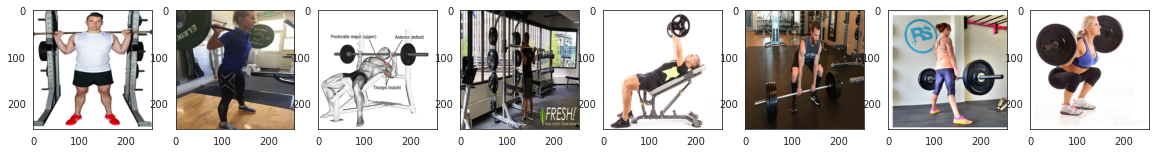

In [15]:
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])

In [16]:
print(X_train.shape, X_test.shape)

(288, 256, 256, 3) (72, 256, 256, 3)


In [17]:
def load_vgg_model():
    
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    
    return model

In [18]:
model = load_vgg_model()
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [19]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [20]:
model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
def build_model(dropout_rate=0):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    
    model = load_vgg_model()
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    # add a dropout layer if rate is not null    
    dropout_layer = layers.Dropout(rate=dropout_rate)
    prediction_layer = layers.Dense(3, activation='softmax')

    if dropout_rate != 0:
      model = Sequential([
          base_model,
          flatten_layer,
          dense_layer,
          dropout_layer,
          prediction_layer
      ])

    else:
      model = Sequential([
          base_model,
          flatten_layer,
          dense_layer,
          prediction_layer
      ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [22]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 500)               16384500  
                                                                 
 dense_1 (Dense)             (None, 3)                 1503      
                                                                 
Total params: 31,100,691
Trainable params: 16,386,003
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
X_train = preprocess_input(X_train) 
#X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [24]:
# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param)) 

In [25]:
n_epochs = 30 
n_epochs_cv = 3
# reduce number of epochs for cross validation for performance reason

n_cv = 2
validation_ratio = 0.10

In [26]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [33]:
model2 = build_model(0.2)

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'auto', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history_2 = model2.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

Epoch 1/50
15/15 [==============================] - 193s 13s/step - loss: 41.8720 - accuracy: 0.6348 - val_loss: 33.1670 - val_accuracy: 0.7069
Epoch 2/50
15/15 [==============================] - 189s 13s/step - loss: 6.2964 - accuracy: 0.9087 - val_loss: 9.8413 - val_accuracy: 0.8276
Epoch 3/50
15/15 [==============================] - 192s 13s/step - loss: 2.3161 - accuracy: 0.9739 - val_loss: 12.9817 - val_accuracy: 0.8621
Epoch 4/50
15/15 [==============================] - 189s 13s/step - loss: 0.8148 - accuracy: 0.9783 - val_loss: 11.3702 - val_accuracy: 0.9138
Epoch 5/50
15/15 [==============================] - 189s 13s/step - loss: 0.0676 - accuracy: 0.9957 - val_loss: 10.1746 - val_accuracy: 0.8966
Epoch 6/50
15/15 [==============================] - 189s 13s/step - loss: 0.0461 - accuracy: 0.9957 - val_loss: 11.0920 - val_accuracy: 0.8793
Epoch 7/50
15/15 [==============================] - 189s 13s/step - loss: 0.1188 - accuracy: 0.9957 - val_loss: 17.1681 - val_accuracy: 0.8621

(<matplotlib.axes._subplots.AxesSubplot at 0x7f754d362450>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f754d305e10>)

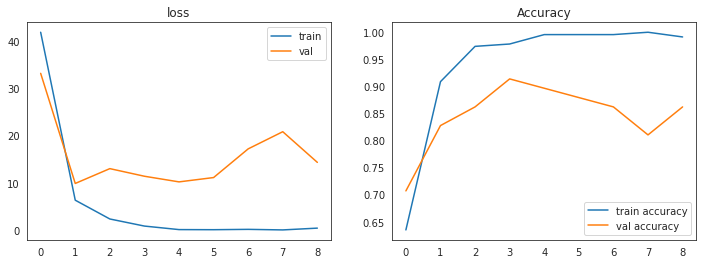

In [34]:
plot_history(history_2)

In [37]:
model3 = build_model(0.3)

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'auto', 
                   patience = 10, 
                   verbose = 1, 
                   restore_best_weights = True)

history_3 = model3.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

Epoch 1/50
15/15 [==============================] - 192s 13s/step - loss: 22.9857 - accuracy: 0.7348 - val_loss: 25.0588 - val_accuracy: 0.8103
Epoch 2/50
15/15 [==============================] - 193s 13s/step - loss: 5.5210 - accuracy: 0.9304 - val_loss: 18.5149 - val_accuracy: 0.8448
Epoch 3/50
15/15 [==============================] - 192s 13s/step - loss: 3.1341 - accuracy: 0.9609 - val_loss: 18.5753 - val_accuracy: 0.8276
Epoch 4/50
15/15 [==============================] - 194s 13s/step - loss: 1.6915 - accuracy: 0.9652 - val_loss: 11.1040 - val_accuracy: 0.8621
Epoch 5/50
15/15 [==============================] - 189s 13s/step - loss: 0.4967 - accuracy: 0.9783 - val_loss: 11.1356 - val_accuracy: 0.8793
Epoch 6/50
15/15 [==============================] - 189s 13s/step - loss: 1.1661 - accuracy: 0.9826 - val_loss: 22.5649 - val_accuracy: 0.8621
Epoch 7/50
15/15 [==============================] - 191s 13s/step - loss: 0.2898 - accuracy: 0.9913 - val_loss: 16.8603 - val_accuracy: 0.879

(<matplotlib.axes._subplots.AxesSubplot at 0x7f753d9d4990>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7541b834d0>)

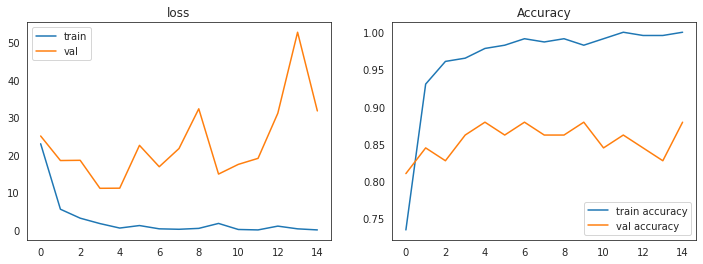

In [38]:
plot_history(history_3)

In [32]:
# create model
# create model
model = KerasClassifier(build_fn=build_model, verbose=1)
start=time()
model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=3,

                    callbacks=[es])
# define parameters and values for grid search 
param_grid = {
    # 'batch_size': [16, 32, 64],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.10, 0.20],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv, scoring='accuracy', verbose=2)
grid_result = grid.fit(X_train, y_train, verbose=1)

# print out results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Epoch 1/3
8/8 [==============================] - 198s 25s/step - loss: 83.4535 - accuracy: 0.4435 - val_loss: 7.2195 - val_accuracy: 0.7586
Epoch 2/3
2/8 [======>.......................] - ETA: 2:06 - loss: 3.0768 - accuracy: 0.9062

KeyboardInterrupt: ignored